# Moving Average - TLDR

In [39]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

- Simulate an MA(2) process and make forecasts:
$$y_t = 0.9\theta_{t–1} + 0.3\theta_{t–2}$$

In [7]:
# MA(2)
ma2 = np.array([1, 0.9, 0.3]) # yt = 0.9 * theta(t-1) + 0.3 * theta(t-2)
ar2 = np.array([1,  0,    0])
 
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

# MA(3)
# ma3 = np.array([1, 0.9, 0.3, 0.2])
# ar3 = np.array([1, 0, 0, 0])

# MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

In [9]:
fig = px.line(MA2_process)
fig.update_layout(
    yaxis_title='Value',
    xaxis_title='Time',
    title='Simulated MA(2) process with 1000 samples'
)  

## EDA
- Run the ADF test, and check if the process is stationary.
- Plot the ACF, and see if there are significant coefficients after lag 2.

In [13]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [17]:
check_stationarity(MA2_process)

ADF Statistic : -14.00544, p-value: 0.00000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 0.20132, p-value: 0.10000
Stationary


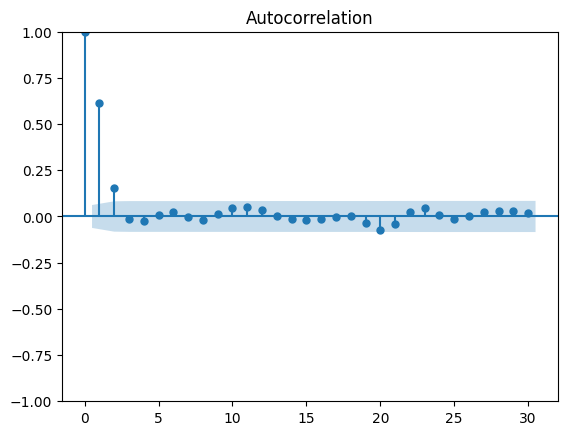

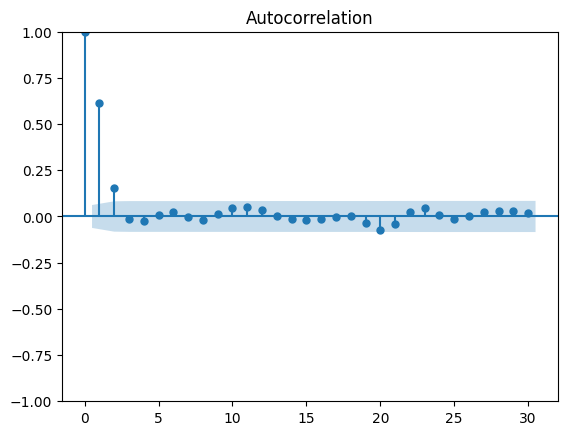

In [18]:
plot_acf(MA2_process)

- The series is stationary & it has 2 significant coefficients after `lag=0`

## Train Test Split

In [35]:
df = pd.DataFrame({'value': MA2_process})

train = df[:800]
test = df[800:]

In [36]:
train.shape, test.shape

((800, 1), (200, 1))

## Forecasting
- forecast 2 timesteps at a time using the `recursive_forecast` function

In [37]:
def rolling_forecast(df: pd.DataFrame,
                     train_len: int, # training length
                     horizon: int,   # horizon of the forecast
                     window: int,    # how many steps to forecast
                     method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    if method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))                  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            # "predicted_mean" method allows us to retrieve the actual value of the forecast 
            # as defined by the statsmodels library.
            oos_pred = predictions.predicted_mean.iloc[-window:]    
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [38]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA2'] = pred_MA2

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-250:].index, y=df[-250:]['value'], name='actual', line = dict(color='royalblue')))

for pred_type in ["pred_mean", "pred_last_value",	"pred_MA2"]: 
    fig.add_trace(go.Scatter(x=test.index, y=test[pred_type], name=pred_type, line = dict(dash='dash')))
fig.update_layout(
    yaxis_title='Value',
    xaxis_title='Time',
    title='Prediction on Test Set'
)  
fig.show()

In [44]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.232354219071749


- The MA(2) model achieves the lowest MSE, therefore, it is the champion model.